This notebook comes after `src/data/2-make_dataset.py` and it is covers different sections:
- DATAFRAMES
- REMOVING OUTLIERS
- BALANCING THE DATA
- FEATURE ENGINEERING
- SCALING THE DATA


And after that comes the different models tried:
- DECISION TREE CLASSIFIER
- RANDOM FOREST CLASSIFIER
- XGBOOST
- KNN
- NAIVE BAYES
- SVM
- PCA
- LOGISTIC REGRESSION
- LDA
- NEURAL NETWORK
- VOTING CLASSIFIER
- ADA BOOST
- GRADIENT TREE BOOSTING

Finally, the export of the final dataframes and model
- EXPORTING FINAL DATA AND MODEL

In [1]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
# from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier, IsolationForest
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from scipy import stats
import joblib


# DATAFRAMES

In [2]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])
df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v7_transformed_data_combined_with_nasa.csv", index_col=['index'])
csv_power_plants.index.rename('index', inplace=True)
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['name','primary_fuel', 'other_fuel1', 'other_fuel2', 'other_fuel3'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

<AxesSubplot:>

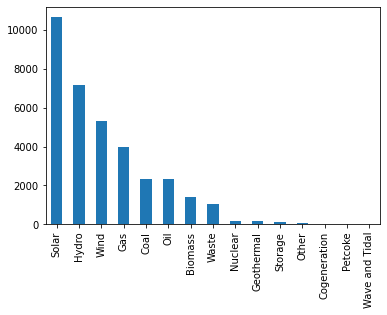

In [3]:
csv_power_plants['primary_fuel'].value_counts().plot.bar()

In [4]:

index_set_to_delete = csv_power_plants[~csv_power_plants['primary_fuel'].isin(['Solar', 'Wind', 'Gas', 'Coal', 'Oil', 'Nuclear'])].index.tolist()
index_set_to_delete += csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

csv_power_plants.drop(index_set_to_delete, inplace = True)

# csv_power_plants.filter(like='other_fuel').columns

# csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])]
# csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])]
# csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])]

In [5]:
columns_to_combine = [
                        'name',
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:28260, [columns_to_combine]],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")

In [6]:
columns_delete = df_transformed_combined.columns.str.contains('mean')

df_transformed_combined = df_transformed_combined.loc[:,~columns_delete]

primary_fuel_transformed
Solar                       10664
Other                        8802
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

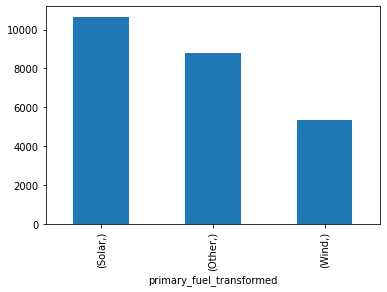

In [7]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [8]:
df_transformed_combined = df_transformed_combined[~(df_transformed_combined['name'].str.contains('CSP') & df_transformed_combined['primary_fuel_transformed'])]

primary_fuel_transformed
Solar                       10649
Other                        8802
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

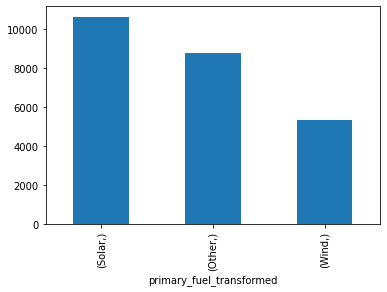

In [9]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [10]:
df_transformed_combined.describe()

,latitude,longitude,ANN_ALLSKY_SFC_SW_DNI_2013,ANN_ALLSKY_SFC_SW_DNI_2014,ANN_ALLSKY_SFC_SW_DNI_2015,ANN_ALLSKY_SFC_SW_DNI_2016,ANN_ALLSKY_SFC_SW_DNI_2017,ANN_ALLSKY_SFC_SW_DNI_2018,ANN_ALLSKY_SFC_SW_DNI_2019,ANN_ALLSKY_SFC_SW_DWN_2013,...,std_WS50M_RANGE_AVG_2018,std_WS50M_RANGE_AVG_2019,capacity_mw,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019
count,24791.000000,24791.000000,24791.000000,24791.000000,24791.000000,24791.000000,24791.000000,24791.000000,24791.000000,24791.000000,...,24791.000000,24791.000000,24791.00000,4213.000000,4810.000000,5601.000000,6283.000000,6796.000000,7045.000000,7302.000000
mean,33.928245,-3.826323,4.386066,4.359166,4.406387,4.473711,4.470474,4.397806,4.425716,4.238151,...,0.682261,0.669360,184.27026,785.793437,875.861542,1008.887201,900.597107,832.720769,630.163237,505.247728
std,20.645427,79.241199,1.375814,1.315913,1.236904,1.329657,1.331693,1.192065,1.263113,0.943968,...,0.214462,0.233416,496.83033,2448.009578,2635.833075,2980.118619,2821.354033,2729.824191,2238.377489,1898.807419
min,-77.847000,-179.977700,1.530000,1.660000,1.640000,1.810000,1.880000,1.790000,1.740000,1.970000,...,0.049000,0.075000,1.00000,-2.653000,-262.902000,-141.014000,-127.507000,-132.033000,-143.592000,-64.543000
25%,31.585800,-77.666150,3.240000,3.290000,3.390000,3.280000,3.370000,3.490000,3.420000,3.600000,...,0.548000,0.509000,5.00000,0.299000,0.714500,1.392000,1.468500,1.551750,1.542000,2.092500
50%,39.632000,-1.433300,4.270000,4.240000,4.350000,4.470000,4.350000,4.130000,4.250000,4.160000,...,0.661000,0.641000,18.00000,15.411000,14.069500,18.329000,11.305000,9.798500,8.584000,8.685500
75%,45.584150,71.823500,5.170000,5.110000,5.100000,5.290000,5.280000,5.020000,5.140000,4.930000,...,0.801000,0.815000,88.00000,278.982000,309.883501,400.634000,316.950500,259.006736,157.317500,125.090141
max,71.292000,178.835900,10.380000,10.580000,10.080000,10.010000,10.320000,9.880000,9.940000,7.240000,...,2.033000,2.162000,8865.00000,31431.080000,32320.917000,37433.607000,32377.477000,36448.643000,35136.000000,31920.368000


In [11]:
# df_transformed_combined = df_transformed_combined.loc[df_transformed_combined['generation_gwh_2013'].notna() & df_transformed_combined['generation_gwh_2014'].notna() & df_transformed_combined['generation_gwh_2015'].notna() & df_transformed_combined['generation_gwh_2016'].notna() & df_transformed_combined['generation_gwh_2017'].notna() & df_transformed_combined['generation_gwh_2018'].notna() & df_transformed_combined['generation_gwh_2019'].notna()]

primary_fuel_transformed
Solar                       10649
Other                        8802
Wind                         5340
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

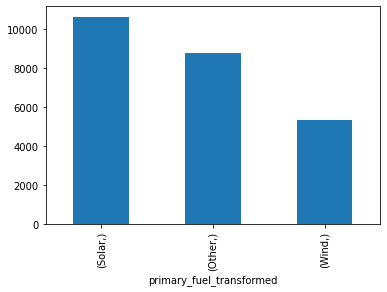

In [12]:
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [13]:
label_encoder = LabelEncoder()
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
df_transformed_combined = df_transformed_combined[df_transformed_combined['primary_fuel_transformed'].notna()]
df_transformed_combined['code_prim_fuel_transf'] = label_encoder.fit_transform(df_transformed_combined['primary_fuel_transformed'])


In [14]:
df_target_equivalent = df_transformed_combined[['primary_fuel_transformed', 'code_prim_fuel_transf']].drop_duplicates()
df_target_equivalent = df_target_equivalent.set_index('code_prim_fuel_transf').sort_index().reset_index().drop(columns=['code_prim_fuel_transf'])
list_target_in_order = df_target_equivalent.squeeze().to_list()

# REMOVING OUTLIERS

In [15]:

# columns_not_consider_outliers = [
#                                     'name',
#                                     'capacity_mw',
#                                     'latitude',
#                                     'longitude',
#                                     'primary_fuel_transformed',
#                                     'code_prim_fuel_transf',
#                                     'generation_gwh_2013',
#                                     'generation_gwh_2014',
#                                     'generation_gwh_2015',
#                                     'generation_gwh_2016',
#                                     'generation_gwh_2017',
#                                     'generation_gwh_2018',
#                                     'generation_gwh_2019'
#                                 ]
# # X = X.loc[:,~columns_delete]                        
# df_transformed_combined_remove_outliers = df_transformed_combined.drop(columns = columns_not_consider_outliers)

In [16]:
# iso = IsolationForest(contamination=0.1)
# yhat = iso.fit_predict(df_transformed_combined_remove_outliers)

In [17]:
# # # select all rows that are outliers
# mask = yhat == -1
# index_outliers = df_transformed_combined[mask].index

In [18]:
# # WITH OUTLIERS
# print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
# df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [19]:
# # WITHOUT OUTLIERS
# df_transformed_combined.drop(index_outliers, axis=0, inplace =True)

# print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
# df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

# BALANCING THE DATA

In [20]:
utils.balancing_data_more_than_1000(df_transformed_combined, 'primary_fuel_transformed')

<AxesSubplot:xlabel='primary_fuel_transformed'>

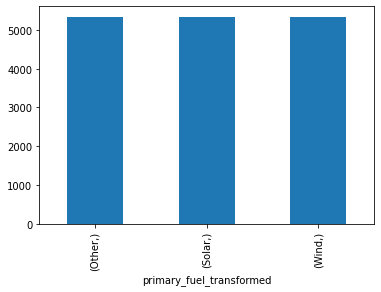

In [21]:
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [22]:
df_transformed_combined.isna().sum()

latitude                          0
longitude                         0
ANN_ALLSKY_SFC_SW_DNI_2013        0
ANN_ALLSKY_SFC_SW_DNI_2014        0
ANN_ALLSKY_SFC_SW_DNI_2015        0
                              ...  
generation_gwh_2016           12019
generation_gwh_2017           11752
generation_gwh_2018           11614
generation_gwh_2019           11506
code_prim_fuel_transf             0
Length: 538, dtype: int64

In [23]:
# index_to_drop = df_transformed_combined[df_transformed_combined['primary_fuel_transformed'] == 'Wind'].index
# df_transformed_combined.drop(index_to_drop, inplace=True)
# X = X.loc[:,~columns_delete]

In [24]:
# df_transformed_combined.isna().sum()
# df_transformed_combined[df_transformed_combined.isna().any(axis=1)]
# df_transformed_combined.dropna(inplace = True)
columns_to_drop = [
                        'name',
                        'capacity_mw',
                        'latitude',
                        'longitude',
                        'primary_fuel_transformed',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        'generation_gwh_2019'
                    ]
df_transformed_combined.drop(columns=columns_to_drop, inplace = True)
# pre_X.dropna(inplace = True)
X = df_transformed_combined.drop(columns=['code_prim_fuel_transf'])
y = df_transformed_combined['code_prim_fuel_transf']

In [25]:
y.value_counts()

1    5340
0    5340
2    5340
Name: code_prim_fuel_transf, dtype: int64

# DIFFERENT DATASETS

In [26]:
#  columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('ANN') | X.columns.str.contains('autumn_CLRSKY_SFC_SW_DWN_2019')
# columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('ANN') | X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('MIN')
# columns_delete = X.columns.str.contains('ALLSKY_KT') | X.columns.str.contains('2019') | X.columns.str.contains('2012') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('MIN') | X.columns.str.contains('ANN')
# columns_delete = X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('ANN') #| X.columns.str.contains('WS50M_RANGE_AVG') | X.columns.str.contains('WS10M_RANGE_AVG') | X.columns.str.contains('CLRSKY_SFC_SW_UP') | X.columns.str.contains('CLRSKY_SFC_SW_DNI') | X.columns.str.contains('CLRSKY_SFC_SW_DIFF') | X.columns.str.contains('ALLSKY_SFC_SW_UP_MAX') | X.columns.str.contains('ALLSKY_SFC_SW_DNI') | X.columns.str.contains('ALLSKY_SFC_LW_UP') | X.columns.str.contains('ALLSKY_SFC_LW_DWN') | X.columns.str.contains('ALLSKY_SFC_SW_UP') | X.columns.str.contains('ALLSKY_SFC_SW_DIFF')
# columns_keep = X.columns.str.contains('ANN') | X.columns.str.contains('SFC_LW_DWN') | X.columns.str.contains('2013')| X.columns.str.contains('MAX')
# columns_delete = X.columns.str.contains('WS') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('2019')
# columns_keep_2012 =  X.columns.str.contains('2012')
X_columns_keep_2013 =  X.columns.str.contains('2013')
X_columns_keep_2014 =  X.columns.str.contains('2014')
columns_keep_2013 =  df_transformed_combined.columns.str.contains('2013') | df_transformed_combined.columns.str.contains('prim_fuel')
columns_keep_2014 =  df_transformed_combined.columns.str.contains('2014') | df_transformed_combined.columns.str.contains('prim_fuel')
# columns_keep = mi_scores[mi_scores > .3].index
# columns_delete = X.columns.str.contains('ANN') | X.columns.str.contains('2019') | X.columns.str.contains('2013') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') 
# columns_delete = X.columns.str.contains('WS50M_2013') | X.columns.str.contains('WS10') | X.columns.str.contains('DNI') | X.columns.str.contains('SFC_LW_UP') | X.columns.str.contains('SFC_SW_DWN') | X.columns.str.contains('autumn') | X.columns.str.contains('winter') | X.columns.str.contains('summer') | X.columns.str.contains('spring') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('2019')
# columns_delete = X.columns.str.contains('WS50M_2013') | X.columns.str.contains('WS10') | X.columns.str.contains('autumn') | X.columns.str.contains('winter') | X.columns.str.contains('summer') | X.columns.str.contains('spring') | X.columns.str.contains('2014') | X.columns.str.contains('2015') | X.columns.str.contains('2016') | X.columns.str.contains('2017') | X.columns.str.contains('2018') | X.columns.str.contains('2019')

# X_2012 = X.loc[:,columns_keep_2012]
X_2013 = X.loc[:,X_columns_keep_2013]
X_2014 = X.loc[:,X_columns_keep_2014]
df_transformed_combined_2013 = df_transformed_combined.loc[:,columns_keep_2013]
df_transformed_combined_2014 = df_transformed_combined.loc[:,columns_keep_2014]
# X = X.loc[:,~columns_delete]

In [ ]:
# X_columns_delete_2014 = X_2014.columns.str.contains('RANGE') | X_2014.columns.str.contains('MAX_AVG') | X_2014.columns.str.contains('median')
# columns_delete_2014 = df_transformed_combined_2014.columns.str.contains('RANGE') | df_transformed_combined_2014.columns.str.contains('MAX_AVG') | df_transformed_combined_2014.columns.str.contains('median')

# X_2014 = X_2014.loc[:,~X_columns_delete_2014]

# df_transformed_combined_2014 = df_transformed_combined_2014.loc[:,~columns_delete_2014]

In [27]:
df_transformed_combined_2014.columns

Index(['ANN_ALLSKY_SFC_SW_DNI_2014', 'ANN_ALLSKY_SFC_SW_DWN_2014',
       'ANN_ALLSKY_SFC_SW_UP_2014', 'ANN_ALLSKY_SFC_SW_UP_MAX_2014',
       'ANN_CLOUD_AMT_DAY_2014', 'ANN_CLRSKY_SFC_SW_DNI_2014',
       'ANN_CLRSKY_SFC_SW_DWN_2014', 'ANN_CLRSKY_SFC_SW_UP_2014',
       'ANN_T2M_2014', 'ANN_WS10M_2014', 'ANN_WS10M_MAX_AVG_2014',
       'ANN_WS10M_RANGE_AVG_2014', 'ANN_WS50M_2014', 'ANN_WS50M_MAX_AVG_2014',
       'ANN_WS50M_RANGE_AVG_2014', 'max_ALLSKY_SFC_SW_DNI_2014',
       'max_ALLSKY_SFC_SW_DWN_2014', 'max_ALLSKY_SFC_SW_UP_2014',
       'max_ALLSKY_SFC_SW_UP_MAX_2014', 'max_CLOUD_AMT_DAY_2014',
       'max_CLRSKY_SFC_SW_DNI_2014', 'max_CLRSKY_SFC_SW_DWN_2014',
       'max_CLRSKY_SFC_SW_UP_2014', 'max_T2M_2014', 'max_WS10M_2014',
       'max_WS10M_MAX_AVG_2014', 'max_WS10M_RANGE_AVG_2014', 'max_WS50M_2014',
       'max_WS50M_MAX_AVG_2014', 'max_WS50M_RANGE_AVG_2014',
       'median_ALLSKY_SFC_SW_DNI_2014', 'median_ALLSKY_SFC_SW_DWN_2014',
       'median_ALLSKY_SFC_SW_UP_2014', 'me

# FEATURE ENGINEERING

## Mutual Information

In [ ]:
mi_scores = utils.make_mi_scores(X_2014, y, "classifier")


In [ ]:
plt.figure(dpi=100, figsize=(8, 30))
utils.plot_scores(mi_scores[mi_scores > .3], "Mutual Information Scores")

## Pearson correlations

In [ ]:
# df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 100)].copy()


corr_matrix = df_transformed_combined_2014.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df_transformed_combined_2014.drop(columns=to_drop, inplace=True)

In [ ]:
# plt.bar(df_all_concat_annual.corr().abs().unstack()['capacity_mw'].sort_values(ascending=False), height=df_all_concat_annual.columns)
corr_matrix = df_transformed_combined_2014.corr().abs()



target_correlations = corr_matrix.unstack()['code_prim_fuel_transf'].sort_values(ascending=False)
# target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# target_correlations[target_correlations > .30]
plt.figure(figsize=(20,10))
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [ ]:
target_correlations[target_correlations > .20].index

In [ ]:
sns.pairplot(df_transformed_combined_2014[target_correlations[target_correlations > .20].index])

In [ ]:
# CLRSKY_SFC_SW_DNI

category = pd.cut(df_transformed_combined_2014['max_CLRSKY_SFC_SW_DWN_2014'], 3).cat.codes.rename('category')

In [ ]:
category.value_counts()

In [ ]:
df_all_concat_w_category = pd.concat([df_transformed_combined_2014[target_correlations[target_correlations > .20].index], category], axis=1)

In [ ]:
sns.pairplot(df_all_concat_w_category, hue='category')

In [ ]:
# mi_scores = utils.make_mi_scores(X, y, "classifier")
# plt.figure(dpi=100, figsize=(8, 30))
# utils.plot_scores(mi_scores, "Mutual Information Scores")

In [ ]:
utils.correlation_matrix(df_transformed_combined_2014)

In [ ]:
# corr_matrix = X.join(y).corr().abs()



# target_correlations = corr_matrix.unstack()['code_prim_fuel_transf'].sort_values(ascending=False)
# # target_correlations = corr_matrix.unstack()['generation_gwh'].sort_values(ascending=False)
# # target_correlations[target_correlations > .20]
# plt.figure(figsize=(20,10))
# # plt.figure(dpi=100, figsize=(4, 10))
# utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [28]:
# df_all_concat_w_category

X = df_transformed_combined_2014.drop(columns=['code_prim_fuel_transf'])
# X = df_transformed_combined_2014[mi_scores[mi_scores > .3].index]
# X = df_transformed_combined_2014[target_correlations[target_correlations > .20].index].drop(columns=['code_prim_fuel_transf'])
# X = df_all_concat_w_category.drop(columns=['code_prim_fuel_transf'])
X = X.reindex(sorted(X.columns), axis=1)
y = df_transformed_combined_2014['code_prim_fuel_transf']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 0)

# SCALING

In [30]:
# X_train_normalized = stats.boxcox(X_train)
x = X_train.values #returns a numpy array
min_max_scaler = MinMaxScaler()
power_transformer = PowerTransformer(method='yeo-johnson')
standard_scaler = StandardScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_train_scaled = pd.DataFrame(x_scaled, index=X_train.index, columns=X_train.columns)

x = X_test.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_test_scaled = pd.DataFrame(x_scaled, index=X_test.index, columns=X_test.columns)

x = X.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_scaled = pd.DataFrame(x_scaled, index=X.index, columns=X.columns)


# DECISION TREE CLASSIFIER

In [ ]:
candidate_max_leaf_nodes = [10, 50, 80, 100, 500, 1200, 1500]
results = {}

results = {node: utils.get_accuracy_tree("classifier",node, X_train, X_test, y_train, y_test) for node in candidate_max_leaf_nodes}
best_tree_size = max(results, key=results.get)
print(best_tree_size)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [ ]:
tree_model = DecisionTreeClassifier(max_leaf_nodes = best_tree_size, random_state=0)
tree_model.fit(X_train, y_train)

In [ ]:
utils.custom_classification_prediction_report(tree_model, X, y, X_test, y_test, list_target_in_order)

In [ ]:
importance = tree_model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {X_train.columns[i]}, Score: {np.around(v*100,2)} %')
	# print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(30,20))
plt.bar([X_train.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

# RANDOM FOREST CLASSIFIER

In [ ]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [int(x) for x in np.arange(10, 501, 10)]
# Minimum numbers of samples required to split a node
min_samples_split = [int(x) for x in np.arange(10, 51, 10)]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.arange(5, 101, 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [int(x) for x in np.arange(10, 501, 10)]


param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [ ]:
rf_model = RandomForestClassifier(random_state=0)
# rf_grid = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv=3, verbose = 2, n_jobs=4)
rf_grid = RandomizedSearchCV(estimator = rf_model, param_distributions = param_grid, n_iter = 150, cv=5, verbose = 2, n_jobs=4)

In [ ]:
# rf_grid.fit(X_train_scaled_pca, y_train)
rf_grid.fit(X_train, y_train)

In [ ]:
rf_grid.best_params_

In [ ]:
rf_grid.score(X_test, y_test)
# rf_grid.score(X_test_scaled_pca, y_test)

In [35]:
rf_model2 = RandomForestClassifier(bootstrap= False,
 max_depth= 420,
 min_samples_leaf= 1,
 min_samples_split= 20,
 n_estimators= 20,
 max_leaf_nodes= 490)
# rf_model2 = rf_grid.best_estimator_

rf_model2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=420, max_leaf_nodes=490,
                       min_samples_split=20, n_estimators=20)

76.94%
[77.59 76.28 76.25 77.09 76.65](%)
Mean: 76.77%, Standard Deviation: 0.51%
              precision    recall  f1-score   support

       Other       0.77      0.73      0.75      1101
       Solar       0.75      0.74      0.74      1069
        Wind       0.79      0.85      0.81      1034

    accuracy                           0.77      3204
   macro avg       0.77      0.77      0.77      3204
weighted avg       0.77      0.77      0.77      3204



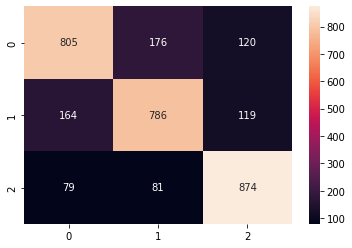

In [36]:
utils.custom_classification_prediction_report(rf_model2, X, y, X_test, y_test, list_target_in_order)

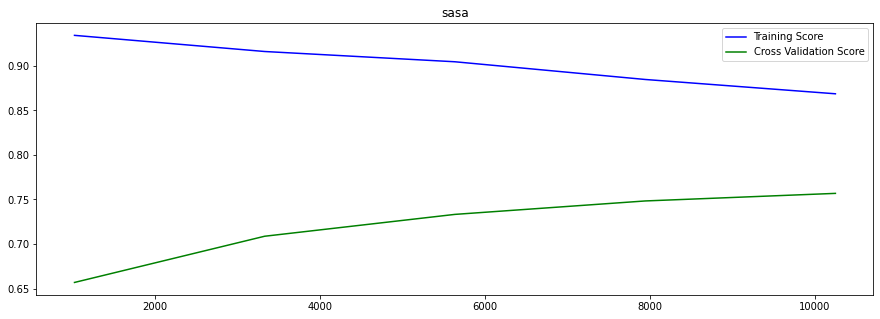

In [38]:
utils.learning_curve_plot("sasa", rf_model2, X_train, y_train)

Feature: ANN_ALLSKY_SFC_SW_DNI_2014, Score: 1.03 %
Feature: ANN_ALLSKY_SFC_SW_DWN_2014, Score: 1.05 %
Feature: ANN_ALLSKY_SFC_SW_UP_2014, Score: 0.89 %
Feature: ANN_ALLSKY_SFC_SW_UP_MAX_2014, Score: 0.58 %
Feature: ANN_CLOUD_AMT_DAY_2014, Score: 0.77 %
Feature: ANN_CLRSKY_SFC_SW_DNI_2014, Score: 1.88 %
Feature: ANN_CLRSKY_SFC_SW_DWN_2014, Score: 1.61 %
Feature: ANN_CLRSKY_SFC_SW_UP_2014, Score: 0.67 %
Feature: ANN_T2M_2014, Score: 1.92 %
Feature: ANN_WS10M_2014, Score: 0.77 %
Feature: ANN_WS10M_MAX_AVG_2014, Score: 1.6 %
Feature: ANN_WS10M_RANGE_AVG_2014, Score: 0.87 %
Feature: ANN_WS50M_2014, Score: 4.2 %
Feature: ANN_WS50M_MAX_AVG_2014, Score: 0.89 %
Feature: ANN_WS50M_RANGE_AVG_2014, Score: 0.73 %
Feature: max_ALLSKY_SFC_SW_DNI_2014, Score: 0.86 %
Feature: max_ALLSKY_SFC_SW_DWN_2014, Score: 1.16 %
Feature: max_ALLSKY_SFC_SW_UP_2014, Score: 0.7 %
Feature: max_ALLSKY_SFC_SW_UP_MAX_2014, Score: 0.76 %
Feature: max_CLOUD_AMT_DAY_2014, Score: 1.31 %
Feature: max_CLRSKY_SFC_SW_DNI_2014, S

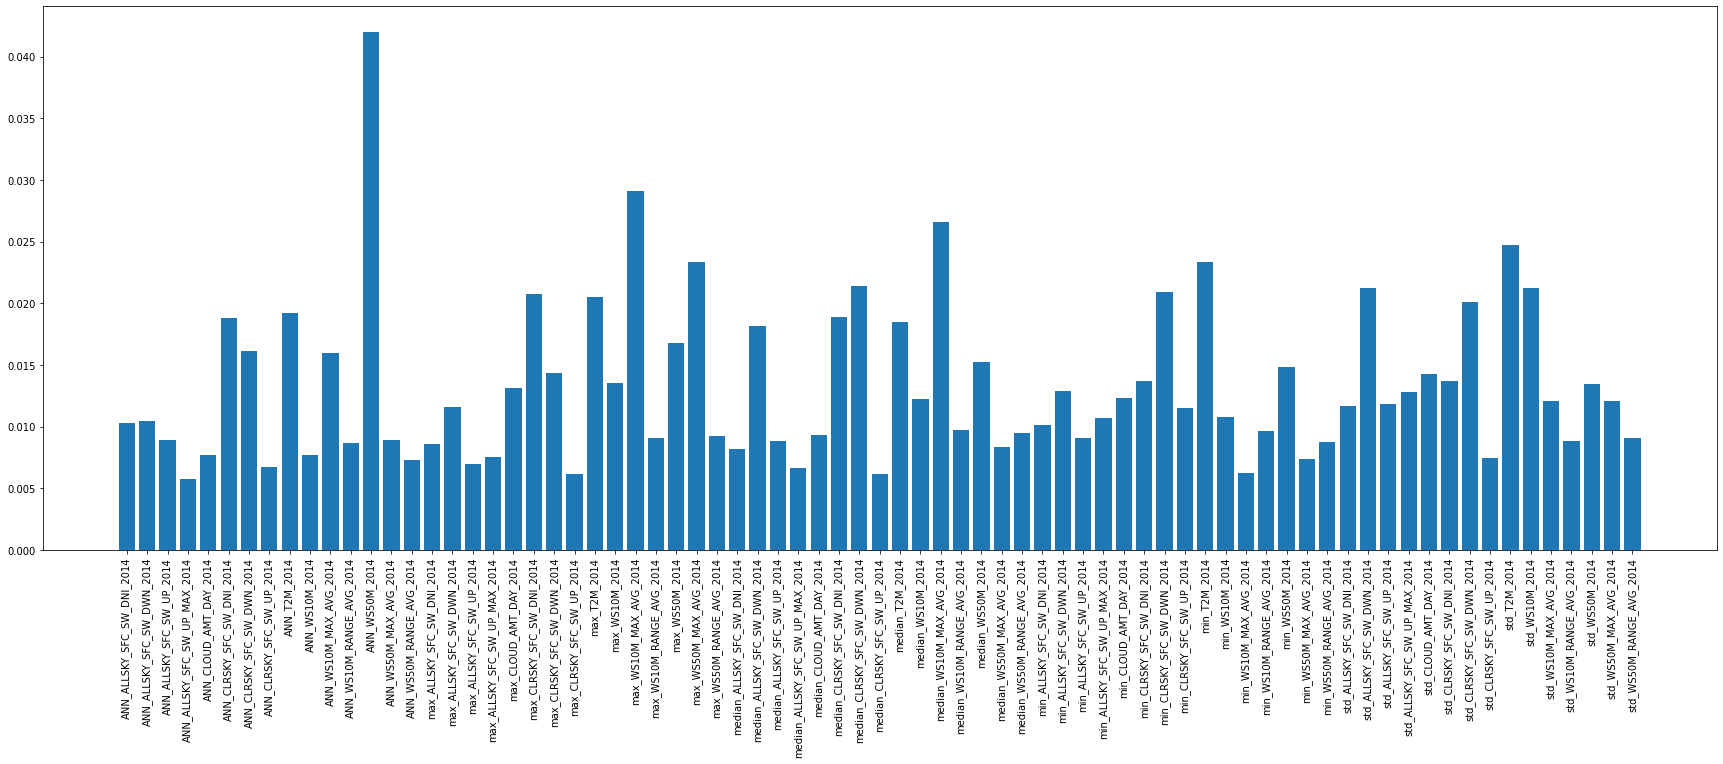

In [39]:
importance = rf_model2.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: {X_train.columns[i]}, Score: {np.around(v*100,2)} %')
	# print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(30,10))
plt.bar([X_train.columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

# XGBOOST

In [ ]:
xgbclass_model_1 = XGBClassifier()
xgbclass_model_1.fit(X_train, y_train)
# xgbclass_model_1.fit(X_train_scaled_pca, y_train)

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
param_grid = {
                'n_estimators': [5,10,50,100,500],
                'learning_rate': [0.001,0.01,0.05,0.1,0.2],
                'max_depth': [2,4,6],
                'gamma': [0.0,0.1,0.2]
            }

In [ ]:
# xgb_grid = GridSearchCV(estimator = XGBClassifier(), param_grid = param_grid, cv=4, verbose = 2, n_jobs=4)
xgb_grid = RandomizedSearchCV(estimator = XGBClassifier(), param_distributions = param_grid, n_iter = 20, cv=5, verbose = 1, n_jobs=4)

In [ ]:
xgb_grid.fit(X_train, y_train)

In [ ]:
xgb_grid.best_params_

In [ ]:
xgb_grid.score(X_test, y_test)

In [ ]:
# xgbclass_model_2 = XGBClassifier(n_estimators=100, learning_rate=0.2, max_depth=6, gamma=0.2, n_jobs=4)
xgbclass_model_2 = XGBClassifier(n_estimators=500, max_depth=6, learning_rate=0.2, gamma=0.0, n_jobs=4)
xgbclass_model_2.fit(X_train, y_train)

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_2, X, y, X_test, y_test, list_target_in_order)

# KNN

In [ ]:
candidate_n_neighbors = np.arange(1,31)
results = {}

# results = {n: utils.get_accuracy_knn("classifier",n, X_train_scaled_pca, X_test_scaled_pca, y_train, y_test) for n in candidate_n_neighbors}
results = {n: utils.get_accuracy_knn("classifier",n, X_train, X_test, y_train, y_test) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [ ]:
knn_model_1 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_1.fit(X_train, y_train)

In [ ]:
utils.custom_classification_prediction_report(knn_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
candidate_n_neighbors = np.arange(1,25)
results = {}
# Write loop to find the ideal tree size from candidate_max_leaf_nodes


results = {n: utils.get_accuracy_knn("classifier",n, X_train_scaled, X_test_scaled, y_train, y_test) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [ ]:
knn_model_2 = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_model_2.fit(X_train_scaled, y_train)

In [ ]:
utils.custom_classification_prediction_report(knn_model_1, X, y, X_test, y_test, list_target_in_order)

# NAIVE BAYES

48.91%
[49.28 49.41 49.44 49.56 49.09](%)
Mean: 49.36%, Standard Deviation: 0.16%
              precision    recall  f1-score   support

       Other       0.52      0.42      0.46      1101
       Solar       0.45      0.50      0.47      1069
        Wind       0.51      0.55      0.53      1034

    accuracy                           0.49      3204
   macro avg       0.49      0.49      0.49      3204
weighted avg       0.49      0.49      0.49      3204



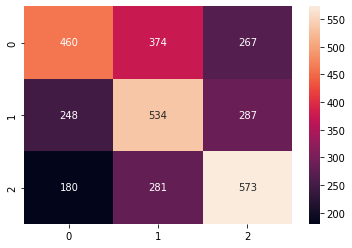

In [41]:
nb_model_1 = GaussianNB()

#Entreno el modelo
nb_model_1.fit(X_train, y_train)
utils.custom_classification_prediction_report(nb_model_1, X, y, X_test, y_test, list_target_in_order)

34.36%
[49.06 48.41 50.03 49.19 50.06](%)
Mean: 49.35%, Standard Deviation: 0.63%
              precision    recall  f1-score   support

       Other       0.34      1.00      0.51      1101
       Solar       0.00      0.00      0.00      1069
        Wind       0.00      0.00      0.00      1034

    accuracy                           0.34      3204
   macro avg       0.11      0.33      0.17      3204
weighted avg       0.12      0.34      0.18      3204



/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: P

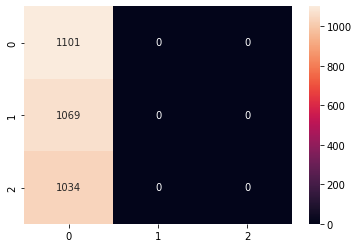

In [42]:
nb_model_2 = GaussianNB()
nb_model_2.fit(X_train_scaled, y_train)

utils.custom_classification_prediction_report(nb_model_2, X, y, X_test, y_test, list_target_in_order)

# SVM

34.36%
[57.58 55.52 56.93 56.84 55.77](%)
Mean: 56.53%, Standard Deviation: 0.77%
              precision    recall  f1-score   support

       Other       0.34      1.00      0.51      1101
       Solar       0.00      0.00      0.00      1069
        Wind       0.00      0.00      0.00      1034

    accuracy                           0.34      3204
   macro avg       0.11      0.33      0.17      3204
weighted avg       0.12      0.34      0.18      3204



/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: P

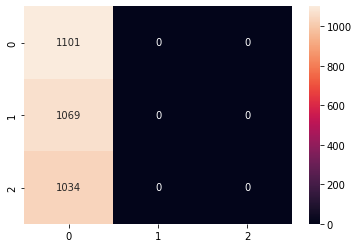

In [43]:
svm_model_1 = SVC(decision_function_shape='ovo')
svm_model_1.fit(X_train_scaled, y_train)

utils.custom_classification_prediction_report(svm_model_1, X, y, X_test, y_test, list_target_in_order)

In [44]:
param_grid = {
                'C': [0.5, 1, 10, 100], # NOTE: values for C must be > 0
                'gamma': ['scale', 1, .1, .01, .001, .0001],
                'kernel': ['rbf', 'linear'], # Some linear fittings last to 7/8 mins. Not recommended at all
                'decision_function_shape': ['ovo', 'ovr']
            }
# svm_grid = GridSearchCV(estimator = SVC(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
svm_grid = RandomizedSearchCV(estimator = SVC(), param_distributions = param_grid, cv=5, verbose = 2, n_jobs=4)

In [45]:
svm_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=10, decision_function_shape=ovo, gamma=1, kernel=linear; total time= 4.0min
[CV] END C=10, decision_function_shape=ovo, gamma=1, kernel=linear; total time= 4.1min
[CV] END C=10, decision_function_shape=ovo, gamma=1, kernel=linear; total time= 4.1min
[CV] END C=10, decision_function_shape=ovo, gamma=1, kernel=linear; total time= 4.3min
[CV] END C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=  32.3s
[CV] END C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=  31.6s
[CV] END C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=  32.4s
[CV] END C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=  30.0s
[CV] END C=10, decision_function_shape=ovo, gamma=0.1, kernel=rbf; total time=  29.6s
[CV] END C=0.5, decision_function_shape=ovr, gamma=0.0001, kernel=linear; total time=  59.9s
[CV] END C=0.5, decision_function_shape=ovr, gamma=0.0001, kernel=li

RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=4,
                   param_distributions={'C': [0.5, 1, 10, 100],
                                        'decision_function_shape': ['ovo',
                                                                    'ovr'],
                                        'gamma': ['scale', 1, 0.1, 0.01, 0.001,
                                                  0.0001],
                                        'kernel': ['rbf', 'linear']},
                   verbose=2)

In [46]:
svm_grid.best_params_

{'kernel': 'rbf', 'gamma': 0.1, 'decision_function_shape': 'ovo', 'C': 10}

In [47]:
svm_grid.score(X_test_scaled, y_test)

0.7718476903870163

77.18%
[76.31 75.75 76.31 75.53 75.22](%)
Mean: 75.82%, Standard Deviation: 0.43%
              precision    recall  f1-score   support

       Other       0.78      0.73      0.75      1101
       Solar       0.75      0.78      0.76      1069
        Wind       0.79      0.82      0.81      1034

    accuracy                           0.77      3204
   macro avg       0.77      0.77      0.77      3204
weighted avg       0.77      0.77      0.77      3204



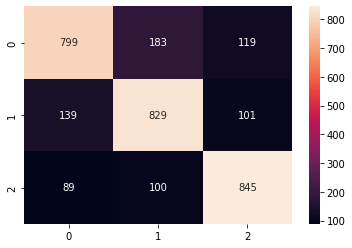

In [50]:
svm_model_2 = SVC(C= 10, gamma= 0.1, kernel='rbf', decision_function_shape= 'ovo')
svm_model_2.fit(X_train_scaled, y_train)

utils.custom_classification_prediction_report(svm_model_2, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

# PCA

In [51]:
pca = PCA(n_components=3)
pca.fit(X_train_scaled)

PCA(n_components=3)

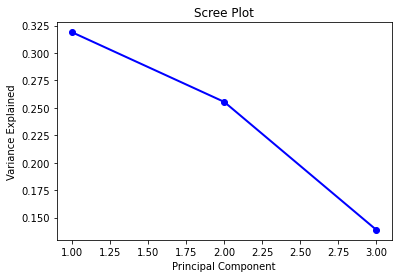

In [52]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

# LOGISTIC REGRESSION

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


61.7%


/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproc

[60.67 59.77 61.24 61.42 62.2 ](%)
Mean: 61.06%, Standard Deviation: 0.81%
              precision    recall  f1-score   support

       Other       0.62      0.53      0.58      1101
       Solar       0.58      0.59      0.58      1069
        Wind       0.65      0.73      0.69      1034

    accuracy                           0.62      3204
   macro avg       0.62      0.62      0.62      3204
weighted avg       0.62      0.62      0.61      3204



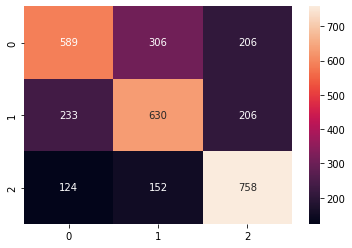

In [53]:
logistic_model_1 = LogisticRegression(multi_class= 'ovr')
logistic_model_1.fit(X_train_scaled, y_train)
utils.custom_classification_prediction_report(logistic_model_1, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

# LDA

In [54]:
lda = LDA(n_components = 2)
X_train_scaled_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_scaled_lda = lda.transform(X_test_scaled)
lda.fit(X_train_scaled_lda, y_train)
# utils.custom_classification_prediction_report(logistic_model_1, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

LinearDiscriminantAnalysis(n_components=2)

0.6182896379525593


<AxesSubplot:>

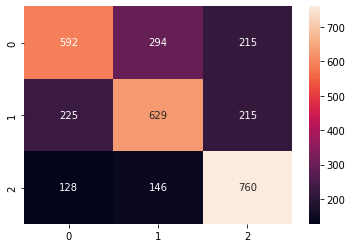

In [55]:

y_pred = lda.predict(X_test_scaled_lda)
print(lda.score(X_test_scaled_lda, y_test))
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# NEURAL NETWORK

In [ ]:
nn_model_1 = MLPClassifier(hidden_layer_sizes=(25,50,25), max_iter=200,activation = 'tanh',solver='adam',random_state=1)
nn_model_1.fit(X_train, y_train)
y_pred = nn_model_1.predict(X_test)
print(nn_model_1.score(X_test, y_test))
confusion_matrix_return = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# BAGGING CLASSIFIER

74.97%
[74.25 73.13 73.22 76.4  75.09](%)
Mean: 74.42%, Standard Deviation: 1.23%
              precision    recall  f1-score   support

       Other       0.77      0.68      0.72      1101
       Solar       0.72      0.75      0.74      1069
        Wind       0.76      0.82      0.79      1034

    accuracy                           0.75      3204
   macro avg       0.75      0.75      0.75      3204
weighted avg       0.75      0.75      0.75      3204



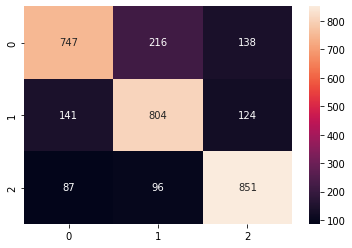

In [57]:
bag_model_1 = BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=50)
bag_model_1.fit(X_train_scaled, y_train)
utils.custom_classification_prediction_report(bag_model_1, X_scaled, y, X_test_scaled, y_test, list_target_in_order)
# y_pred = bag_model_1.predict(X_test_scaled)
# print(bag_model_1.score(X_test_scaled, y_test))

# results_cvs = cross_val_score(bag_model_1, X_train_scaled, y_train, cv=5)
# print(results_cvs)
# print(f'Mean: {results_cvs.mean()}, Standard Deviation: {results_cvs.std()}')
# confusion_matrix_return = confusion_matrix(y_test, y_pred)
# sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')


# print(np.around(bag_model_1.score(X_test_scaled, y_test),3))
# # If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
# results_cvs = cross_val_score(bag_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
# print(np.around(results_cvs, 3))
# print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
# confusion_matrix_return = confusion_matrix(y_test, y_pred)
# sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

In [ ]:
classifier = {
        'KNeighbors': KNeighborsClassifier(n_neighbors=9),
        'DecisionTree': DecisionTreeClassifier(max_leaf_nodes=50),
        'XGBClassifier': XGBClassifier()
    }

for name, estimator in classifier.items():
    bag_class = BaggingClassifier(base_estimator=estimator, n_estimators=5).fit(X_train_scaled, y_train)
    
    bag_pred = bag_class.predict(X_test_scaled)

    print(f'Accuracy Bagging with {name}: {accuracy_score(bag_pred, y_test)}')
    print('')
    print(f'Mean: {cross_val_score(bag_class, X, y, cv=5).mean()}, Standard Deviation: {cross_val_score(tree_model, X, y, cv=5).std()}')
    print('')

# VOTING CLASSIFIER

74.81%
[75.47 75.25 75.34 74.94 75.37](%)
Mean: 75.27%, Standard Deviation: 0.18%
              precision    recall  f1-score   support

       Other       0.75      0.69      0.72      1101
       Solar       0.72      0.76      0.74      1069
        Wind       0.78      0.80      0.79      1034

    accuracy                           0.75      3204
   macro avg       0.75      0.75      0.75      3204
weighted avg       0.75      0.75      0.75      3204



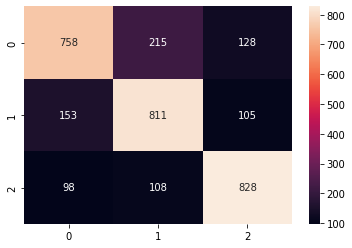

In [59]:


votclass_model_1 = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier(n_neighbors=9)), ('dt', DecisionTreeClassifier(max_leaf_nodes=50)), ('xgb', XGBClassifier())], voting='hard')
votclass_model_1.fit(X_train_scaled, y_train)

utils.custom_classification_prediction_report(votclass_model_1, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

# y_pred = votclass_model_1.predict(X_test_scaled)

# print(np.around(votclass_model_1.score(X_test_scaled, y_test),3))
# # If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
# results_cvs = cross_val_score(votclass_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
# print(np.around(results_cvs, 3))
# print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
# confusion_matrix_return = confusion_matrix(y_test, y_pred)
# sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# ADABOOST

60.3%
[60.55 61.86 61.05 62.05 61.8 ](%)
Mean: 61.46%, Standard Deviation: 0.57%
              precision    recall  f1-score   support

       Other       0.59      0.54      0.56      1101
       Solar       0.57      0.57      0.57      1069
        Wind       0.65      0.71      0.68      1034

    accuracy                           0.60      3204
   macro avg       0.60      0.60      0.60      3204
weighted avg       0.60      0.60      0.60      3204



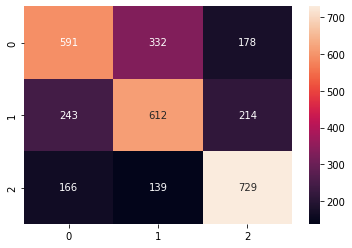

In [60]:
adaBoost_model_1 = AdaBoostClassifier()
adaBoost_model_1.fit(X_train_scaled, y_train)


utils.custom_classification_prediction_report(adaBoost_model_1, X_scaled, y, X_test_scaled, y_test, list_target_in_order)

# y_pred = adaBoost_model_1.predict(X_test_scaled)

# print(np.around(adaBoost_model_1.score(X_test_scaled, y_test),3))
# # If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
# results_cvs = cross_val_score(adaBoost_model_1, X_scaled, y, cv=StratifiedKFold(shuffle = True))
# print(np.around(results_cvs, 3))
# print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
# confusion_matrix_return = confusion_matrix(y_test, y_pred)
# sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# GRADIENT TREE BOOSTING

72.1%
[73.66 71.54 71.94 71.13 73.31](%)
Mean: 72.32%, Standard Deviation: 1.0%
              precision    recall  f1-score   support

       Other       0.73      0.66      0.69      1101
       Solar       0.69      0.72      0.71      1069
        Wind       0.75      0.79      0.77      1034

    accuracy                           0.72      3204
   macro avg       0.72      0.72      0.72      3204
weighted avg       0.72      0.72      0.72      3204



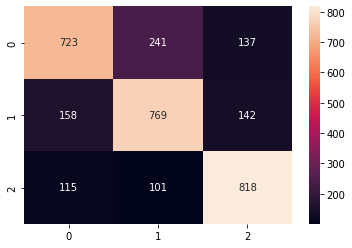

In [62]:
gradboost_model_1 = GradientBoostingClassifier()
gradboost_model_1.fit(X_train, y_train)

utils.custom_classification_prediction_report(gradboost_model_1, X, y, X_test, y_test, list_target_in_order)


# y_pred = gradboost_model_1.predict(X_test)
# print(np.around(gradboost_model_1.score(X_test, y_test),3))
# # If data is unordered in nature (i.e. non - Time series) then shuffle = True is right choice.
# results_cvs = cross_val_score(gradboost_model_1, X, y, cv=StratifiedKFold(shuffle = True))
# print(np.around(results_cvs, 3))
# print(f'Mean: {np.around(results_cvs.mean(),3)}, Standard Deviation: {np.around(results_cvs.std(),3)}')
# confusion_matrix_return = confusion_matrix(y_test, y_pred)
# sns.heatmap(confusion_matrix_return, annot=True, fmt = 'g')

# EXPORTING FINAL DATA AND MODEL

In [ ]:
X.to_csv(utils.DIR_DATA_PROCESSED/"classification_X.csv")
y.to_csv(utils.DIR_DATA_PROCESSED/"classification_y.csv")
df_target_equivalent.to_csv(utils.DIR_DATA_PROCESSED/"classification_y_real_values.csv")

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_1, X, y, X_test, y_test, list_target_in_order)

In [ ]:
utils.custom_classification_prediction_report(xgbclass_model_2, X, y, X_test, y_test, list_target_in_order)

In [ ]:
joblib.dump(xgbclass_model_1, utils.DIR_MODELS/"xgbclass_model_1.pkl")